In [1]:
import os
import json
import torch
import re
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16

##Load models

In [2]:
PRM_ADAPTER_REPO = "devangb4/prm-qwen3-8b-bf16-6k"
BASE_MODEL_NAME = "Qwen/Qwen3-8B"
GENERATOR_MODEL = "Qwen/Qwen3-0.6B"

In [3]:
gen_tok = AutoTokenizer.from_pretrained(GENERATOR_MODEL, trust_remote_code=True)
if gen_tok.pad_token is None:
    gen_tok.pad_token = gen_tok.eos_token
gen_model = AutoModelForCausalLM.from_pretrained(
    GENERATOR_MODEL,
    device_map="cuda",
    dtype=DTYPE,
    trust_remote_code=True
).eval()

prm_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    device_map="cuda",
    dtype=DTYPE,
    trust_remote_code=True,
)
prm_model = PeftModel.from_pretrained(prm_base, PRM_ADAPTER_REPO)
prm_tok = AutoTokenizer.from_pretrained(PRM_ADAPTER_REPO, trust_remote_code=True)

# Load Head
hidden_size = prm_model.config.hidden_size
prm_head = torch.nn.Linear(hidden_size, 1).to(DEVICE).to(DTYPE)
try:
    from huggingface_hub import snapshot_download
    local_dir = snapshot_download(PRM_ADAPTER_REPO)
    head_path = os.path.join(local_dir, "prm_head.bin")
    if os.path.exists(head_path):
        prm_head.load_state_dict(torch.load(head_path, map_location=DEVICE))
        print("PRM Head loaded.")
    else:
        print("WARNING: prm_head.bin not found. Using random init.")
except Exception as e:
    print(f"WARNING: Head load failed: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/876 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/61.4M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

prm_head.bin:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/123M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

export_metadata.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

prm_head_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

PRM Head loaded.


##Experiment Settings

In [4]:
NUM_PROBLEMS = 500           # Test set size
BEAM_WIDTH = 4               # K: How many beams to keep alive
BEAM_EXPANSION = 4           # M: How many candidates to generate per beam at each step
MAX_STEPS = 25               # Max reasoning steps
BEST_OF_N_COUNT = 16         # N for the baseline comparison

OUTPUT_FILE = "beam_search_results.jsonl"

##Utils

In [5]:
def extract_answer(text):
    if not text: return ""
    matches = re.findall(r"Final\s*Answer\s*:\s*(.+)", text, flags=re.I)

    if matches:
        ans = matches[-1].strip()
    else:
        ans = text.strip()

    ans = re.sub(r"\s*(mph|km/h|units?|percent|%|\$)", "", ans, flags=re.I)
    nums = re.findall(r"-?\d+(?:\.\d+)?", ans.replace(",", ""))
    return nums[-1] if nums else ans

In [6]:
def is_correct(gold, pred):
    try: return abs(float(gold) - float(pred)) < 1e-6
    except: return str(gold).strip() == str(pred).strip()

In [7]:
def format_step_prm(problem, prev_steps, current_step):
    if current_step is None:
        raise ValueError("format_step_prm got current_step=None")

    prev_text = " ".join(prev_steps).strip()
    clean_step = re.sub(r"^\s*Step\s*\d+[:)]\s*", "", current_step).strip()

    if prev_text:
        return (
            f"Problem: {problem}\n"
            f"Previous steps: {prev_text}\n"
            f"Current step: {clean_step}\n"
            "Is this step correct?"
        )
    else:
        return (
            f"Problem: {problem}\n"
            f"Current step: {clean_step}\n"
            "Is this step correct?"
        )

In [8]:
@torch.inference_mode()
def score_step_single(prompt):
    if prompt is None:
        raise ValueError("score_step_single got prompt=None (format_step_prm is broken)")

    inputs = prm_tok(
        text=prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    ).to(DEVICE)

    out = prm_model(**inputs, output_hidden_states=True, use_cache=False)
    last_hidden = out.hidden_states[-1]
    idx = inputs.attention_mask.sum(dim=1) - 1
    h_last = last_hidden[0, idx, :]
    logits = prm_head(h_last.to(prm_head.weight.dtype)).squeeze(-1)
    return torch.sigmoid(logits.float()).item()

In [9]:
def generate_next_step_candidates(current_text, n_candidates=4):
    prompt = current_text
    if not prompt.endswith("\n"): prompt += "\n"

    steps = re.findall(r"Step\s*(\d+)", prompt)
    next_step_num = int(steps[-1]) + 1 if steps else 1
    step_header = f"Step {next_step_num}:"

    input_text = prompt + step_header

    if input_text is None:
        raise ValueError("input_text is None in generate_next_step_candidates")

    inputs = gen_tok(text=[input_text] * n_candidates, return_tensors="pt", padding=True).to(DEVICE)

    with torch.inference_mode():
        gen_out = gen_model.generate(
            **inputs,
            max_new_tokens=60,
            temperature=0.8,
            do_sample=True,
            pad_token_id=gen_tok.pad_token_id,
            eos_token_id=gen_tok.encode("\n")[0]
        )

    candidates = []
    for seq in gen_out:
        full_text = gen_tok.decode(seq, skip_special_tokens=True)
        new_content = full_text[len(prompt):].strip()

        if "Step" in new_content[len(step_header):]:
             new_content = new_content[:new_content.find("Step", len(step_header))]

        candidates.append(new_content.strip())

    return list(set(candidates))


In [10]:
def build_prompt(problem):
    example_problem = "A train travels at 60 mph for 2 hours and then at 40 mph for 1 hour. What is the train's average speed for the entire journey?"

    example_solution = (
        "Step 1: Calculate the distance traveled during the first part of the journey.\n"
        "Distance1 = speed * time = 60 mph * 2 hours = 120 miles.\n"
        "Step 2: Calculate the distance traveled during the second part of the journey.\n"
        "Distance2 = speed * time = 40 mph * 1 hour = 40 miles.\n"
        "Step 3: Calculate the total distance traveled.\n"
        "Total Distance = Distance1 + Distance2 = 120 miles + 40 miles = 160 miles.\n"
        "Step 4: Calculate the total time taken for the journey.\n"
        "Total Time = Time1 + Time2 = 2 hours + 1 hour = 3 hours.\n"
        "Step 5: Calculate the average speed for the entire journey.\n"
        "Average Speed = Total Distance / Total Time = 160 miles / 3 hours = 53.33 mph.\n"
        "Final Answer: 53.33"
    )

    return (
        "You are a careful math tutor. Solve the problem in clear, numbered steps exactly as shown in the example. STRICTLY FOLLOW THE FORMAT\n\n"
        "### Example Problem:\n"
        f"{example_problem}\n"
        "### Example Solution:\n"
        f"{example_solution}\n\n"
        "--- END OF EXAMPLE ---\n\n"
        "### New Problem:\n"
        f"{problem}\n"
        "### Your Solution:\n"
    )

In [11]:
def run_beam_search(problem):

    initial_prompt = build_prompt(problem)
    # Beam State: List of dicts
    beams = [{"text": initial_prompt, "steps": [], "score": 0.0, "finished": False}]

    for _ in range(MAX_STEPS):
        all_candidates = []

        # 1. Expand all active beams
        active_beams_exist = False
        for beam in beams:
            if beam["finished"]:
                all_candidates.append(beam)
                continue

            active_beams_exist = True

            # Generate M next steps
            next_step_opts = generate_next_step_candidates(beam["text"], n_candidates=BEAM_EXPANSION)

            for step_cand in next_step_opts:
                # Check if finished
                is_final = "Final Answer" in step_cand or len(beam["steps"]) >= MAX_STEPS - 1

                # Score with PRM
                prm_prompt = format_step_prm(problem, beam["steps"], step_cand)
                step_prob = score_step_single(prm_prompt)

                # Log-sum score (add log probability)
                new_score = beam["score"] + math.log(step_prob + 1e-10)

                new_beam = {
                    "text": beam["text"] + "\n" + step_cand,
                    "steps": beam["steps"] + [step_cand],
                    "score": new_score,
                    "finished": is_final
                }
                all_candidates.append(new_beam)

        if not active_beams_exist:
            break

        # 2. Prune: Keep top K global candidates
        beams = sorted(all_candidates, key=lambda x: x["score"], reverse=True)[:BEAM_WIDTH]

        if all(b["finished"] for b in beams):
            break

    return beams[0] # Return best beam

In [12]:
def run_best_of_n(problem, n=16):
    prompt = build_prompt(problem)
    if prompt is None:
        raise ValueError("prompt is None in run_best_of_n")
    inputs = gen_tok([prompt] * n, return_tensors="pt", padding=True).to(DEVICE)

    with torch.inference_mode():
        gen_out = gen_model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            do_sample=True,
            pad_token_id=gen_tok.pad_token_id
        )

    candidates = []
    texts = gen_tok.batch_decode(gen_out, skip_special_tokens=True)

    for text in texts:
        if prompt in text: sol_body = text.split(prompt)[1]
        else: sol_body = text


        # Split and Score
        steps = [s.strip() for s in sol_body.split('\n') if s.strip()] # Simple split for BoN
        current_score = 0.0
        prev = []

        for step in steps:
            prm_prompt = format_step_prm(problem, prev, step)
            prob = score_step_single(prm_prompt)
            current_score += math.log(prob + 1e-10)
            prev.append(step)

        candidates.append({
            "text": text,
            "pred": extract_answer(sol_body),
            "score": current_score
        })

    # Return best candidate
    best = sorted(candidates, key=lambda x: x["score"], reverse=True)[0]
    return best

##Run

In [13]:
ds = load_dataset("gsm8k", "main", split="test")
rng = random.Random()
indices = rng.sample(range(len(ds)), NUM_PROBLEMS)
subset = ds.select(indices)

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [14]:
results = []

for i, row in tqdm(enumerate(subset), total=NUM_PROBLEMS):
    problem = row['question']
    gold = extract_answer(row['answer'])

    # 1. Run Beam Search
    beam_start = time.time()
    best_beam = run_beam_search(problem)
    beam_time = time.time() - beam_start
    beam_pred = extract_answer(best_beam["text"])

    # 2. Run Best-of-N (Baseline)
    bon_start = time.time()
    best_bon = run_best_of_n(problem, n=BEST_OF_N_COUNT)
    bon_time = time.time() - bon_start
    bon_pred = best_bon["pred"]

    results.append({
        "idx": i,
        "problem": problem,
        "gold": gold,
        "beam_pred": beam_pred,
        "beam_correct": is_correct(gold, beam_pred),
        "beam_steps": len(best_beam["steps"]),
        "bon_pred": bon_pred,
        "bon_correct": is_correct(gold, bon_pred),
    })

    if (i+1) % 10 == 0:
        # Intermediate save
        with open(OUTPUT_FILE, "w") as f:
            for r in results: f.write(json.dumps(r)+"\n")

  0%|          | 0/500 [00:00<?, ?it/s]


Final Results on 500 samples:
Beam Search (K=4): 53.80%
Best-of-N (N=16): 58.20%


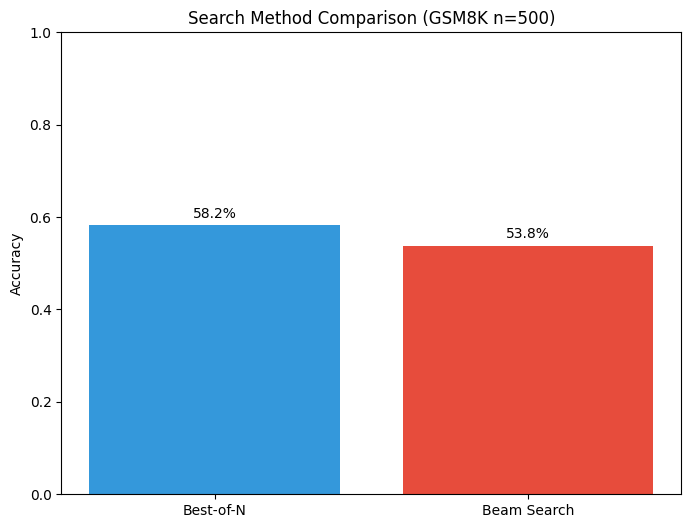

In [15]:
beam_acc = sum(r["beam_correct"] for r in results) / len(results)
bon_acc = sum(r["bon_correct"] for r in results) / len(results)

print(f"\nFinal Results on {NUM_PROBLEMS} samples:")
print(f"Beam Search (K={BEAM_WIDTH}): {beam_acc:.2%}")
print(f"Best-of-N (N={BEST_OF_N_COUNT}): {bon_acc:.2%}")

labels = ['Best-of-N', 'Beam Search']
accs = [bon_acc, beam_acc]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accs, color=['#3498db', '#e74c3c'])
plt.ylabel('Accuracy')
plt.title(f'Search Method Comparison (GSM8K n={NUM_PROBLEMS})')
plt.ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.1%}', ha='center', va='bottom')

plt.savefig("beam_search_comparison.png")

In [16]:
print(results)

[{'idx': 0, 'problem': 'Jeff’s work is 3 miles away.  He walks there and back each day he works.  How many miles does he walk if he has to work 5 times a week?', 'gold': '30', 'beam_pred': '30', 'beam_correct': True, 'beam_steps': 3, 'bon_pred': '30', 'bon_correct': True}, {'idx': 1, 'problem': 'A class of 200 students is split into 3 groups such that 2 of them are equal in number and the last one (which is the smallest) is 10 less than each of the other groups. How many students are in this (smallest) group?', 'gold': '60', 'beam_pred': '20', 'beam_correct': False, 'beam_steps': 8, 'bon_pred': '60', 'bon_correct': True}, {'idx': 2, 'problem': "Sandra's neighbor gives her a basket of 9 eggs every time she babysits their daughter. To make a Spanish flan, she needs 3 eggs. If Sandra has been tasked to make 15 Spanish flans for her school fundraiser, how many times does Sandra have to babysit?", 'gold': '5', 'beam_pred': '5', 'beam_correct': True, 'beam_steps': 2, 'bon_pred': '5', 'bon_co